In [0]:
# considering change label to one-hot encoding
# list data as array described as graph
# date set is balanced
# sliding window hyperparameters waiting to be tuned

In [2]:
# considering change label to one-hot encoding
# list data as array described as graph
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [42]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("drive/Colab Notebooks") 
!ls

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
 1-1_tensor_tutorial.ipynb		  'RNN_project (58c845cd).ipynb'
 1-2_autograd_tutorial.ipynb		   RNN_project.ipynb
'1-3_neural_networks_tutorial (1).ipynb'   RNN_project_slidingW.ipynb
'1-4_cifar10_tutorial (1).ipynb'	  'RNN_project_slidingW _olld.ipynb'
 1_hello_tensorflow.ipynb		   RNN_standardize_sliding_window.ipynb
 2_getting_started.ipynb		   RNN_Vanilla.ipynb
'3_mnist_from_scratch (6f53deeb).ipynb'    Untitled
 3_mnist_from_scratch.ipynb		   Untitled0.ipynb
'AE(just one model).ipynb'		   Untitled1.ipynb
 data					   Untitled2.ipynb
 drive					   Untitled3.ipynb
 ee239_1000epoch.ipynb			   Untitled4.ipynb
 EEG_AE.ipynb				   Untitled5.ipynb
 HW5_CNN.ipynb				   Untitled6.ipynb
 record.txt				   Untitled7.ipynb
 record.txt_without_weights		   Untitled8.ipynb
 record_without_weights.txt		  'Untitled (93cd11de)'
 results


In [0]:
# library import
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from time import time


In [0]:
# define hyperparameters and functions
batch_size = 100
num_epoches = 100

window_step = 5
window_length = 10

learning_rate = 1e-3
betas=(0.9, 0.999)
weight_decay=5e-4


index = np.arange(2115)
np.random.shuffle(index)
training_index, valid_index = index[:1715], index[1715:]

train_acc = []
test_acc = []


use_gpu = torch.cuda.is_available()  # determine whether it has gpu speed up


def plot_acc(train_acc, test_acc):
    plt.plot(test_acc, label = "test")
    plt.plot(train_acc, label = "train")
    plt.xlabel("eopch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("The accuracy against epoch")
    plt.show()


def flatten(x):
    """
    Input:
    - Tensor of shape (N, D1, ..., DM)
    Output:
    - Tensor of shape (N, D1 * ... * DM)
    """
    x_shape = x.size()
    new_shape = 1
    for i in range(len(x_shape) - 1):
        new_shape *= x_shape[i + 1]
    x_flat = x.reshape((x_shape[0],new_shape))
    return x_flat
  
def sliding_window(length, shift, data):
    """
    Input:
    - raw eeg data
    Output:
    - processed window signals, everytime shifted with "shift" units, window length is "length"
    """
    p, e, d = data.shape
    
    if(d%shift==0):
        new_data_size = d//shift
        new_data = np.zeros((p, e, new_data_size))
        for i in range(d//shift):
            new_data[:, :, i] = np.mean(data[:, :, i*shift:(i+1)*shift+length], axis = 2)

    else:
        new_data_size = d//shift+1
        new_data = np.zeros((p, e, new_data_size))
        for i in range(d//shift):
            new_data[:, :, i] = np.mean(data[:, :, i*shift:(i+1)*shift+length], axis = 2)
        new_data[:, :, new_data_size-1] = np.mean(data[:, :, (new_data_size-1)*shift:], axis = 2)
    
    return new_data

In [45]:
# load data into environment
X_test = np.load("data/X_test.npy")
y_test = np.load("data/y_test.npy")
person_train_valid = np.load("data/person_train_valid.npy")
X_train_valid = np.load("data/X_train_valid.npy")
y_train_valid = np.load("data/y_train_valid.npy")
person_test = np.load("data/person_test.npy")

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 25, 1000)
Test data shape: (443, 25, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [0]:
# transform data into pytorch form
# extract first 22 signals out of 25 signals
X_train_valid = X_train_valid[:, :22, :]
X_train = X_train_valid[training_index]
X_valid = X_train_valid[valid_index]
X_test = X_test[:, :22, :]

# standardize data
X_train = X_train.reshape((1715, 22*1000))
X_valid = X_valid.reshape((400, 22*1000))
X_test = X_test.reshape((443, 22*1000))

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

X_train = X_train.reshape((1715, 22, 1000))
X_valid = X_valid.reshape((400, 22, 1000))
X_test = X_test.reshape((443, 22, 1000))

# sliding window process
X_train = sliding_window(window_length, window_step, X_train)
X_valid = sliding_window(window_length, window_step, X_valid)
X_test = sliding_window(window_length, window_step, X_test)


y_train = y_train_valid[training_index]
y_valid = y_train_valid[valid_index]


trainset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train - 769).long(), torch.from_numpy(person_train_valid[training_index]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

validset = torch.utils.data.TensorDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid - 769).long())
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)

testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test - 769).long())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)




In [0]:
# network architecture
class eeg_lstm(nn.Module):
     def __init__(self, in_feature=22, hidden_feature=256, num_class=4, signal_length=1000):
          super(eeg_lstm, self).__init__()
          self.rnn = nn.LSTM(input_size=in_feature, hidden_size=hidden_feature, num_layers=2, bidirectional=True) #using 5 layers lstm
          self.relu = nn.ReLU()
          self.dropout = nn.Dropout(0.75)
          self.classifier = nn.Linear(hidden_feature*signal_length*2, num_class) #using linear to classify the output
          
     def forward(self, x):
          out, _ = self.rnn(x) #使用默认的隐藏状态，得到的out是（1000， batch， hidden_feature）
          #print(out.shape)
          out = self.dropout(out)
          out = self.relu(out)
          out = self.dropout(out)
          #out = out[-101:-1,:,:]#取序列中的最后一个，大小是（batch， hidden_feature)
          out = flatten(out.permute(1, 0, 2))
          #print(out.shape)
          out = self.classifier(out) #得到分类结果
          #tag_score = F.log_softmax(out, dim=1)
          return out

In [0]:
# initiate lstm network
model = eeg_lstm(signal_length=X_train.shape[2])  
if use_gpu:
    model = model.cuda()


# define loss function and optimizer
weights = [0.23, 0.34, 0.25, 0.18]
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)
# criterion = nn.CrossEntropyLoss()
# parameters in Adam could be tuned
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay)

train_acc = []
val_acc = []

In [0]:
def train(epoch):
  t0 = time()

  
  model.train()
  print('epoch {}'.format(epoch + 1))
  print('*' * 10)
  running_loss = 0.0
  running_acc = 0.0
  for batch_idx, (signals, tags, subjects) in enumerate(trainloader):
      # Step 1. Remember that Pytorch accumulates gradients.
      # We need to clear them out before each instance
      model.zero_grad()

      # Step 2. Get our inputs ready for the network, that is, turn them into
      # Tensors of word indices.
      signals = signals.squeeze(1)
      signals = signals.permute(2, 0, 1)
      if use_gpu:
          signals = Variable(signals).cuda()
          tags = Variable(tags).cuda()
          subjects = Variable(subjects).cuda()
      else:
          signals = Variable(signals)
          tags = Variable(tags)
          subjects = Variable(subjects)

      # Step 3. Run our forward pass.
      tag_scores = model(signals)

      # Step 4. Compute the loss, gradients, and update the parameters by
      #  calling optimizer.step()
      loss = criterion(tag_scores, tags)
      
      for i in range(tags.size(0)):
        tmp_score = tag_scores[i,:]
        tmp_score = tmp_score.unsqueeze(0)
#         print(tmp_score.size(0))
#         print(tmp_score.size(1))

        tmp_tag = torch.Tensor([tags[i]]).long()
        if(use_gpu):
          tmp_tag = Variable(tmp_tag).cuda()
          tmp_score = Variable(tmp_score).cuda()
        else:
          tmp_tag = Variable(tmp_tag)
          tmp_score = Variable(tmp_score).cuda()
          
        if(subjects[i]==1 or subjects[i]==2):
          loss+=5.0*criterion(tmp_score, tmp_tag) / tags.size(0)
        elif(subjects[i]==6):
          loss+=3.0*criterion(tmp_score, tmp_tag) / tags.size(0)

      
      running_loss += loss.data.item() * tags.size(0)
      _, pred = torch.max(tag_scores, 1)
      num_correct = (pred == tags).sum()
      running_acc += num_correct.data.item()
      # 向后传播
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  train_acc.append(running_acc/(len(X_train)))
  print('Finish {} epoch, Loss: {:.6f}, Acc: {:.6f}'.format(
      epoch + 1, running_loss / (len(X_train)), running_acc / (len(
          X_train))))

  model.eval()
  eval_loss = 0.
  eval_acc = 0.
  for batch_idx, (signals, tags) in enumerate(validloader):

      signals = signals.squeeze(1)
      signals = signals.permute(2, 0, 1)
      if use_gpu:
          signals = Variable(signals).cuda()
          tags = Variable(tags).cuda()
      else:
          signals = Variable(signals)
          tags = Variable(tags)

      tag_scores = model(signals)
      loss = criterion(tag_scores, tags)
      eval_loss += loss.data.item() * tags.size(0)
      _, pred = torch.max(tag_scores, 1)
      num_correct = (pred == tags).sum()
      eval_acc += num_correct.data.item()
  val_acc.append(eval_acc / (len(X_valid)))
  print('Validation Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(
      X_valid)), eval_acc / (len(X_valid))))
  
  print()

In [0]:
def test_class(subject):
  model.eval()
  eval_loss = 0.
  eval_acc = 0.
  total = 0.
  
  for batch_idx, (signals, tags) in enumerate(testloader):
    signals = signals.squeeze(1)
    signals = signals.permute(2, 0, 1)
    if use_gpu:
        signals = Variable(signals).cuda()
        tags = Variable(tags).cuda()
    else:
        signals = Variable(signals)
        tags = Variable(tags)

    tag_scores = model(signals)
#     for i in range(9):
#       tmp_index = tags.index(i)
#       tmo_tag = tag
    loss = criterion(tag_scores, tags)
    #print(tags)
    eval_loss += loss.data.item() * tags.size(0)
    _, pred = torch.max(tag_scores, 1)
    total += tags.size(0)
    num_correct = (pred == tags).sum()
    eval_acc += num_correct.data.item()
  print('Class:{}, Testing Loss:{:.6f}, Acc:{:6f}.'.format(subject+1, eval_loss/len(testloader), eval_acc / total))
  print()

In [13]:
x_test_list_class=[[] for i in range(4)]
y_test_list_class=[[] for i in range(4)]
for i in range(len(y_test)):
  x_test_list_class[int(y_test[i])-769].append(X_test[i,:22,:])
  y_test_list_class[int(y_test[i])-769].append(y_test[i])

x_test_class=np.array(x_test_list_class)
y_test_class=np.array(y_test_list_class)

train_acc = []
print(y_test_list_class)

[[769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769], [770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 7

In [14]:

for epoch in range(num_epoches):  # again, normally you would NOT do 300 epochs, it is toy data
  train(epoch)

  if (epoch+1)%10==0:
    print("#############################")
    for i in range(4):
      testset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(x_test_class[i])).float(), torch.from_numpy(np.array(y_test_class[i]) - 769).long())
      testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
      test_class(i)
    testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test[:,:22,:]).float(), torch.from_numpy(y_test - 769).long())
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_class(-1)
    print("#############################")


epoch 1
**********
Finish 1 epoch, Loss: 3.389054, Acc: 0.281633
Validation Loss: 1.320276, Acc: 0.340000

epoch 2
**********
Finish 2 epoch, Loss: 3.238547, Acc: 0.345773
Validation Loss: 1.260863, Acc: 0.477500

epoch 3
**********
Finish 3 epoch, Loss: 3.070186, Acc: 0.402332
Validation Loss: 1.172361, Acc: 0.497500

epoch 4
**********
Finish 4 epoch, Loss: 2.964111, Acc: 0.467055
Validation Loss: 1.233634, Acc: 0.365000

epoch 5
**********
Finish 5 epoch, Loss: 2.833699, Acc: 0.495627
Validation Loss: 1.101027, Acc: 0.545000

epoch 6
**********
Finish 6 epoch, Loss: 2.716519, Acc: 0.514869
Validation Loss: 1.053925, Acc: 0.555000

epoch 7
**********
Finish 7 epoch, Loss: 2.628823, Acc: 0.539942
Validation Loss: 1.045034, Acc: 0.550000

epoch 8
**********
Finish 8 epoch, Loss: 2.599255, Acc: 0.544606
Validation Loss: 1.034202, Acc: 0.560000

epoch 9
**********
Finish 9 epoch, Loss: 2.531608, Acc: 0.544606
Validation Loss: 1.032348, Acc: 0.577500

epoch 10
**********
Finish 10 epoch, 

In [0]:
record_train = train_acc
record_val = val_acc


In [0]:
file = open('record.txt','w')
train_acc_str = ""
val_acc_str = ""
for e in record_train:
  train_acc_str += str(e)
  train_acc_str += ','
for e in record_val:
  val_acc_str += str(e)
  val_acc_str += ','
  
file.writelines(train_acc_str)
file.writelines(val_acc_str)
file.close()

In [17]:
file = open('record.txt','r')
s = file.read()
print(s)
file.close()

0.2816326530612245,0.3457725947521866,0.40233236151603496,0.46705539358600584,0.4956268221574344,0.5148688046647231,0.5399416909620991,0.5446064139941691,0.5446064139941691,0.5836734693877551,0.5743440233236151,0.6081632653061224,0.6104956268221574,0.6256559766763848,0.6192419825072887,0.6379008746355685,0.6658892128279883,0.6699708454810496,0.6600583090379009,0.6559766763848397,0.6746355685131196,0.6565597667638484,0.682798833819242,0.6868804664723032,0.7107871720116619,0.7061224489795919,0.7061224489795919,0.7294460641399417,0.721865889212828,0.7236151603498542,0.7393586005830903,0.7510204081632653,0.753935860058309,0.7527696793002916,0.7568513119533528,0.7568513119533528,0.758600583090379,0.7679300291545189,0.7685131195335277,0.7702623906705539,0.7725947521865889,0.7807580174927113,0.7848396501457726,0.8023323615160349,0.8011661807580175,0.8029154518950438,0.7965014577259475,0.8174927113702624,0.8198250728862974,0.8163265306122449,0.8239067055393586,0.8408163265306122,0.833236151603

In [18]:
record = s.split(',')
print(record)

['0.2816326530612245', '0.3457725947521866', '0.40233236151603496', '0.46705539358600584', '0.4956268221574344', '0.5148688046647231', '0.5399416909620991', '0.5446064139941691', '0.5446064139941691', '0.5836734693877551', '0.5743440233236151', '0.6081632653061224', '0.6104956268221574', '0.6256559766763848', '0.6192419825072887', '0.6379008746355685', '0.6658892128279883', '0.6699708454810496', '0.6600583090379009', '0.6559766763848397', '0.6746355685131196', '0.6565597667638484', '0.682798833819242', '0.6868804664723032', '0.7107871720116619', '0.7061224489795919', '0.7061224489795919', '0.7294460641399417', '0.721865889212828', '0.7236151603498542', '0.7393586005830903', '0.7510204081632653', '0.753935860058309', '0.7527696793002916', '0.7568513119533528', '0.7568513119533528', '0.758600583090379', '0.7679300291545189', '0.7685131195335277', '0.7702623906705539', '0.7725947521865889', '0.7807580174927113', '0.7848396501457726', '0.8023323615160349', '0.8011661807580175', '0.80291545

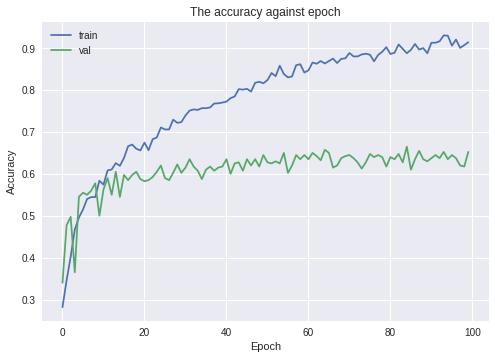

In [19]:
import numpy as np
import matplotlib.pyplot as plt



plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title("The accuracy against epoch")

plt.legend()

plt.show()

In [0]:
def test_people(subject):
  model.eval()
  eval_loss = 0.
  eval_acc = 0.
  total = 0.
  
  for batch_idx, (signals, tags) in enumerate(testloader):
    signals = signals.squeeze(1)
    signals = signals.permute(2, 0, 1)
    if use_gpu:
        signals = Variable(signals).cuda()
        tags = Variable(tags).cuda()
    else:
        signals = Variable(signals)
        tags = Variable(tags)

    tag_scores = model(signals)
#     for i in range(9):
#       tmp_index = tags.index(i)
#       tmo_tag = tag
    loss = criterion(tag_scores, tags)
    #print(tags)
    eval_loss += loss.data.item() * tags.size(0)
    _, pred = torch.max(tag_scores, 1)
    total += tags.size(0)
    num_correct = (pred == tags).sum()
    eval_acc += num_correct.data.item()
  print('people:{}, Testing Loss:{:.6f}, Acc:{:6f}.'.format(subject+1, eval_loss/len(testloader), eval_acc / total))
  print()

In [53]:
x_test_list=[[] for i in range(9)]
y_test_list=[[] for i in range(9)]
for i in range(len(person_test)):
  x_test_list[int(person_test[i][0])].append(X_test[i, :22, :])
  y_test_list[int(person_test[i][0])].append(y_test[i])

x_test_08=np.array(x_test_list)
y_test_08=np.array(y_test_list)


print(y_test_list)

[[770, 769, 771, 772, 772, 771, 771, 772, 772, 769, 771, 772, 771, 769, 770, 770, 772, 772, 771, 769, 771, 770, 769, 770, 772, 771, 769, 770, 770, 772, 771, 771, 770, 770, 771, 769, 769, 769, 769, 772, 770, 771, 769, 770, 772, 771, 769, 772, 771, 770], [770, 771, 769, 772, 772, 770, 770, 772, 772, 771, 770, 770, 772, 770, 769, 770, 770, 770, 771, 769, 769, 770, 772, 771, 771, 769, 770, 771, 769, 771, 772, 771, 769, 770, 772, 769, 769, 772, 772, 769, 772, 771, 770, 770, 769, 771, 769, 772, 770, 772], [770, 769, 769, 770, 771, 769, 769, 772, 771, 771, 772, 770, 772, 770, 769, 769, 770, 772, 770, 769, 769, 769, 772, 771, 772, 769, 772, 769, 771, 772, 771, 770, 772, 770, 770, 772, 769, 770, 772, 769, 769, 771, 771, 769, 771, 772, 772, 770, 769, 772], [769, 772, 770, 771, 770, 769, 771, 769, 770, 772, 769, 770, 771, 771, 770, 771, 772, 770, 769, 772, 770, 770, 770, 772, 771, 769, 770, 771, 770, 772, 771, 772, 772, 770, 770, 772, 770, 771, 771, 770, 772, 771, 772, 772, 771, 771, 770, 772, 77

In [54]:

for epoch in range(num_epoches):  # again, normally you would NOT do 300 epochs, it is toy data
  train(epoch)

  if epoch%10==9:
    print("#############################")
    for i in range(9):
      testset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(x_test_08[i])).float(), torch.from_numpy(np.array(y_test_08[i]) - 769).long())
      testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
      test_people(i)
    testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test[:, :22, :]).float(), torch.from_numpy(y_test - 769).long())
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_people(-1)
    print("#############################")

  if train_acc[-1]>95:
    break

        

epoch 1
**********
Finish 1 epoch, Loss: 3.376347, Acc: 0.282799
Validation Loss: 1.327142, Acc: 0.310000

epoch 2
**********
Finish 2 epoch, Loss: 3.205587, Acc: 0.357434
Validation Loss: 1.289492, Acc: 0.382500

epoch 3
**********
Finish 3 epoch, Loss: 3.036238, Acc: 0.402915
Validation Loss: 1.191168, Acc: 0.447500

epoch 4
**********
Finish 4 epoch, Loss: 2.961383, Acc: 0.451895
Validation Loss: 1.185003, Acc: 0.427500

epoch 5
**********
Finish 5 epoch, Loss: 2.846095, Acc: 0.488047
Validation Loss: 1.140660, Acc: 0.470000

epoch 6
**********
Finish 6 epoch, Loss: 2.756713, Acc: 0.505539
Validation Loss: 1.091038, Acc: 0.477500

epoch 7
**********
Finish 7 epoch, Loss: 2.580185, Acc: 0.520700
Validation Loss: 1.064045, Acc: 0.530000

epoch 8
**********
Finish 8 epoch, Loss: 2.586823, Acc: 0.541108
Validation Loss: 1.088995, Acc: 0.545000

epoch 9
**********
Finish 9 epoch, Loss: 2.465375, Acc: 0.566181
Validation Loss: 1.084972, Acc: 0.507500

epoch 10
**********
Finish 10 epoch, 

In [0]:
print(use_gpu)

True
